## Load imports

In [65]:
# Load necessary packages
import os
import rioxarray as rioxr
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
import fiona
from shapely.geometry import shape

# File Path
landsat_path = 'data/landsat8-2018-01-26-sb-simplified.nc'

# Task 2: Visualizing Fire Scars through False Color

## Instructions

- Update the following cell to include a link to your GitHub repository:

**UPDATE THIS LINK**  
https://github.com/takeenshamloo/eds220-hwk4

- Review the [complete rubric for this task](https://docs.google.com/document/d/1-Zm731BLVCs1MXHT5R1H9rr6uvcwHnMZQ2q8xkQ_fWM/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.

- Delete all the comments initially included in this notebook (ex: `# Your code here`).

## About the Data

The dataset contains Landsat reflectance data for red, green, blue, near infrared, and shortwave infrared bands. This task involves reprojecting and visualizing these data.


## Section 3: True Color Image

This section focuses on creating a true color image from the Landsat data.

In [66]:
# (a) Construct file path and import data
landsat_data = rioxr.open_rasterio(landsat_path)

In [67]:
# (b) Explore data and write summary
print(landsat_data)
print("Variables:", landsat_data.variables.keys())
print("Dimensions:", landsat_data.dims)
print(landsat_data.head)

<xarray.Dataset>
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...
Variables: KeysView(Frozen({'band': <xarray.IndexVariable 'band' (band: 1)>
array([1]), 'x': <xarray.IndexVariable 'x' (x: 870)>
array([121305., 121575., 121845., ..., 355395., 355665., 355935.])
Attributes:
    axis:           X
    crs:            EPSG:32611
    long_name:      x coordinate of projection
    resolution:     30
    standard_name:  projection_x_coordinate
    units:          metre
    _FillValue:     nan, 'y': <xarray.IndexVariable 'y' (y: 731)>
array([3952395., 3952125., 3951

### Section 3 Summary

The Landsat dataset has data for five bands: **red**, **green**, **blue**, **near-infrared (nir08)**, and **shortwave-infrared (swir22)**. The data is organized in three dimensions:
- **x**: 870 values (east-west)
- **y**: 731 values (north-south)
- **band**: A single redundant band dimension, which we’ll remove.

The data uses the **EPSG:32611** coordinate system (UTM Zone 11N) with 30-meter resolution. All the reflectance values are floats, and we need to scale them for proper RGB visualization. Clouds in the image can cause really bright spots, so we’ll use `robust = True` to balance the colors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


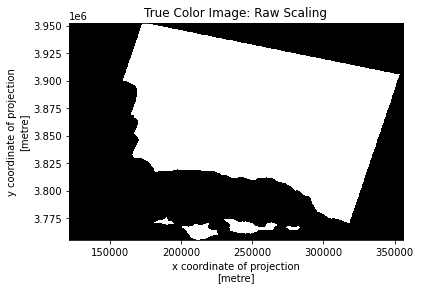

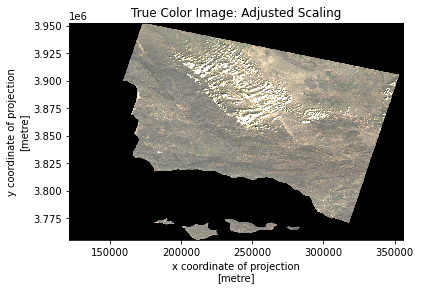

In [68]:
# (c) Drop the band dimension
landsat_data = landsat_data.squeeze(dim = "band")

# (d) True Color Image: Raw RGB Plot
landsat_data[['red', 'green', 'blue']].to_array().plot.imshow()
plt.title("True Color Image: Raw Scaling")
plt.show()

# (e) True Color Image: Adjusted Scale for Clouds
landsat_data[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)
plt.title("True Color Image: Adjusted Scaling")
plt.show()

## Section 4: False Color Image

This section creates a false color image using SWIR, NIR, and Red bands.

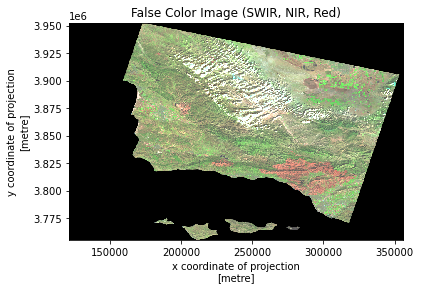

In [70]:
# False Color Image using SWIR, NIR, and Red bands
landsat_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title("False Color Image (SWIR, NIR, Red)")
plt.show()

## Section 5: Map

This section overlays the false color image with the fire perimeter data.

/Users/takeenshamloo/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return srs
No handles with labels found to put in legend.


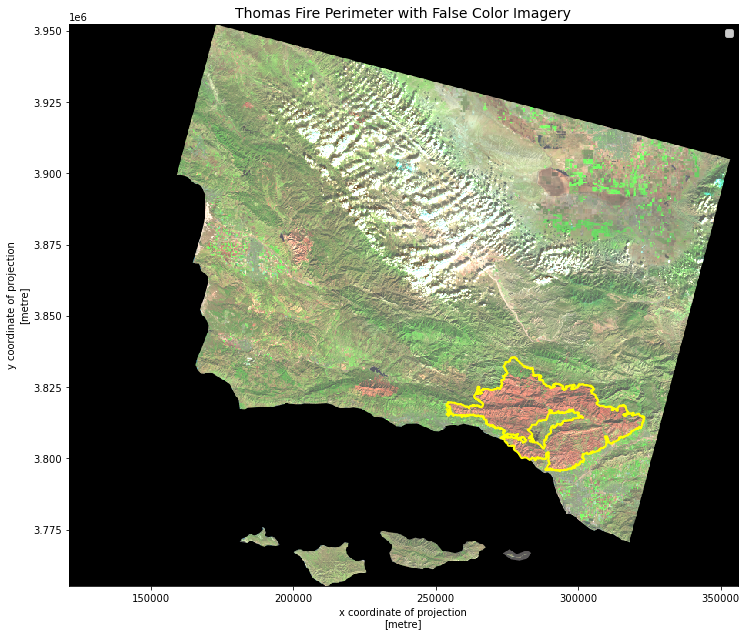

In [76]:
# Load the fire perimeter shapefile using Fiona
shapefile_path = "data/fire_perimeter/California_Fire_Perimeters_(all).shp"
with fiona.open(shapefile_path, "r") as shapefile:
    records = [feature for feature in shapefile]
    shapefile_crs = shapefile.crs  # Extract CRS from Fiona

# Convert Fiona records to a GeoDataFrame
geometries = [shape(record["geometry"]) for record in records]
attributes = [record["properties"] for record in records]
fire_perimeter = gpd.GeoDataFrame(attributes, geometry = geometries, crs = shapefile_crs)

# Filter for the 2017 Thomas Fire
thomas_fire = fire_perimeter[
    (fire_perimeter["YEAR_"] == 2017) &
    (fire_perimeter["FIRE_NAME"].str.contains("Thomas", case = False))
]

# Explicitly set CRS for thomas_fire from fire_perimeter
thomas_fire.set_crs(fire_perimeter.crs, inplace = True)

# Align CRS of Thomas Fire to Landsat data
thomas_fire = thomas_fire.to_crs(landsat_data.rio.crs)

# Overlay False Color Image with Thomas Fire Perimeter
fig, ax = plt.subplots(figsize = (12, 12))
landsat_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax)
thomas_fire.plot(ax = ax, edgecolor = "yellow", facecolor="none", linewidth = 2, label = "Thomas Fire Perimeter")

# Add title and legend
plt.title("Thomas Fire Perimeter using False Color Imagery", fontsize = 14)
plt.legend()
plt.show()
